In [1]:
# IMPORT SOME MODULES =========================================================================
%pylab inline

from astropy.io import fits
from matplotlib.mlab import griddata
from matplotlib.colors import ColorConverter
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import leastsq
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools as it
from string import join
import os

from densitycontour import densitycontour

from styles.paper import *
from styles.colors import *
from styles.labels import *

from tools.plots import *
from tools.stats import *
from tools.photometry import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
# sizes ---------------------------------------------------------------------------------------
NR = 20

# colors --------------------------------------------------------------------------------------
cc = ColorConverter()

ssag_cl = samples["dark"]
sdss_cl = seds["sdss"]
sdss_sg = cc.to_rgba(seds["sdss"], alpha=0.5)
jpas_cl = seds["jpas"]
jpas_sg = cc.to_rgba(seds["jpas"], alpha=0.5)
spec_cl = seds["spec"]
spec_sg = cc.to_rgba(seds["spec"], alpha=0.5)

# output dir ----------------------------------------------------------------------------------
od = os.path.expandvars("$HOME/Documents/Publications/PhD-thesis/figures/")

In [3]:
ssag_tta = genfromtxt("../inputs/tta_cb13/ssag/set_catalog.txt", dtype=None, names=True)

mask_ws = ssag_tta["Av_lib"]<=1.5
working_set = ssag_tta["name"][mask_ws]

ssag_tta = ssag_tta[mask_ws].repeat(NR)

lcolor = ssag_tta["u"]-ssag_tta["r"]
kw_mod = [field.replace("lib", "mod") for field in ssag_tta.dtype.names if "_lib" in field]
kw = [field.rstrip("_mod") for field in kw_mod]

sdss_tta = genfromtxt("../inputs/tta_cb13/outs/sdss/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
jpas_tta = genfromtxt("../inputs/tta_cb13/outs/jpas/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
spec_tta = genfromtxt("../inputs/tta_cb13/outs/spec/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
sdss_lsn = genfromtxt("../inputs/proof_sn20/outs/sdss/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
jpas_lsn = genfromtxt("../inputs/proof_sn20/outs/jpas/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
spec_lsn = genfromtxt("../inputs/proof_sn20/outs/spec/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
sdss_hsn = genfromtxt("../inputs/proof_sn45/outs/sdss/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
jpas_hsn = genfromtxt("../inputs/proof_sn45/outs/jpas/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
spec_hsn = genfromtxt("../inputs/proof_sn45/outs/spec/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
sdss_noi = genfromtxt("../inputs/proof_biasless/outs/sdss/dynbas_output.log", dtype=None, names=True)[mask_ws].repeat(NR)
jpas_noi = genfromtxt("../inputs/proof_biasless/outs/jpas/dynbas_output.log", dtype=None, names=True)[mask_ws].repeat(NR)
spec_noi = genfromtxt("../inputs/proof_biasless/outs/spec/dynbas_output.log", dtype=None, names=True)[mask_ws].repeat(NR)


ssag_tta["M_lib"] = log10(ssag_tta["M_lib"])

sdss_tta["M_mod"] = log10(sdss_tta["M_mod"])
jpas_tta["M_mod"] = log10(jpas_tta["M_mod"])
spec_tta["M_mod"] = log10(spec_tta["M_mod"])
sdss_noi["M_mod"] = log10(sdss_noi["M_mod"])
jpas_noi["M_mod"] = log10(jpas_noi["M_mod"])
spec_noi["M_mod"] = log10(spec_noi["M_mod"])
sdss_lsn["M_mod"] = log10(sdss_lsn["M_mod"])
jpas_lsn["M_mod"] = log10(jpas_lsn["M_mod"])
spec_lsn["M_mod"] = log10(spec_lsn["M_mod"])
sdss_hsn["M_mod"] = log10(sdss_hsn["M_mod"])
jpas_hsn["M_mod"] = log10(jpas_hsn["M_mod"])
spec_hsn["M_mod"] = log10(spec_hsn["M_mod"])

ocolor = loadtxt("data/sample-sim/ur_color.txt")
jpas_obs = zeros(ocolor.size, dtype=zip(kw_mod, ["<f8"]*6))
spec_obs = copy(jpas_obs)
for m in kw_mod:
    spec_obs[m] = loadtxt("data/sample-sim/SPEC_{}.txt".format(m))
    jpas_obs[m] = loadtxt("data/sample-sim/JPAS_{}.txt".format(m))

In [4]:
def unbiased_disc(model_spec, model_jpas, residual_spec, residual_jpas, obs_color, lib_color):
    n, our_edge = histogram(obs_color, 15, range=(1.3,3.0))
    n, lur_edge = histogram(lib_color, 15, range=(1.3,3.0))
    
    discrepancy = zeros(model_jpas.size)
    for i in xrange(our_edge.size-1):
        obin = (obs_color>=our_edge[i])&(obs_color<our_edge[i+1])
        lbin = (lib_color>=lur_edge[i])&(lib_color<lur_edge[i+1])
        
        discrepancy[obin] = (model_jpas[obin]-model_spec[obin]) - (median(residual_jpas[lbin])-median(residual_spec[lbin]))
    
    return discrepancy

sdss_res = dict(
    M=err(ssag_tta["M_lib"], sdss_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], sdss_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], sdss_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], sdss_tta["Av_mod"], False)
)
jpas_res = dict(
    M=err(ssag_tta["M_lib"], jpas_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_tta["Av_mod"], False)
)
spec_res = dict(
    M=err(ssag_tta["M_lib"], spec_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_tta["Av_mod"], False)
)
sdss_noiseless_res = dict(
    M=err(ssag_tta["M_lib"], sdss_noi["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_noi["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_noi["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], sdss_noi["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], sdss_noi["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], sdss_noi["Av_mod"], False)
)
jpas_noiseless_res = dict(
    M=err(ssag_tta["M_lib"], jpas_noi["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_noi["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_noi["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_noi["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_noi["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_noi["Av_mod"], False)
)
spec_noiseless_res = dict(
    M=err(ssag_tta["M_lib"], spec_noi["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_noi["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_noi["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_noi["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_noi["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_noi["Av_mod"], False)
)
tta_con = dict([(k, unbiased_disc(spec_tta[k+"_mod"], jpas_tta[k+"_mod"], spec_res[k], jpas_res[k], lcolor, lcolor)) for k in kw])
obs_con = dict([(k, unbiased_disc(spec_obs[k+"_mod"], jpas_obs[k+"_mod"], spec_res[k], jpas_res[k], ocolor, lcolor)) for k in kw])

pags = lcolor>2.22
sfgs = ~pags
algs = pags|sfgs

In [5]:
def residual_correlation_scatter(residuals, res_names, properties, limits=(-0.9,+0.9), nbins=30, masks=[sfgs, pags]):
    x, y1, y2, z = properties
    
    fig = figure(figsize=(7,4))

    ax11 = subplot2grid((20,31), (0,0), rowspan=10, colspan=10, ylabel=Delta[y1], xticklabels=[], xlim=limits, ylim=limits)
    ax21 = subplot2grid((20,31), (10,0), rowspan=10, colspan=10, ylabel=Delta[y2], xlim=limits, ylim=limits)
    ax12 = subplot2grid((20,31), (0,10), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=limits, ylim=limits)
    ax22 = subplot2grid((20,31), (10,10), rowspan=10, colspan=10, xlabel=Delta[x], yticklabels=[], xlim=limits, ylim=limits)
    ax13 = subplot2grid((20,31), (0,20), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=limits, ylim=limits)
    ax23 = subplot2grid((20,31), (10,20), rowspan=10, colspan=10, yticklabels=[], xlim=limits, ylim=limits)

    axs = array([[ax11, ax12, ax13], [ax21, ax22, ax23]])
    ac = subplot2grid((20,31), (1,30), rowspan=18)

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.7, wspace=0.7)

    for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
        y = y1 if i==0 else y2
        res = residuals[j]

        ct = axs[i, j].scatter(res[x][sfgs], res[y][sfgs], c=res[z][sfgs], s=7, marker="*", lw=0, cmap=cm.Spectral_r, vmin=-0.25, vmax=0.45, norm=MidpointNormalize(midpoint=0.0))
        ct = axs[i, j].scatter(res[x][pags], res[y][pags], c=res[z][pags], s=4, marker="o", lw=0, cmap=cm.Spectral_r, vmin=-0.25, vmax=0.45, norm=MidpointNormalize(midpoint=0.0))

        axs[i,j].axvline(ls=":", color=samples["dark"], lw=0.5)
        axs[i,j].axhline(ls=":", color=samples["dark"], lw=0.5)

        sample_data = densitycontour.ScatterData(res[x], res[y])
        raster = sample_data.rasterize(nbins_x=nbins, nbins_y=nbins, clipping=[last(nbins,limits)]*2)
        raster.pdf = gaussian_filter(raster.pdf, sigma=1.5)
        contours = densitycontour.NaiveContourVisualizer(raster, mode="nearest")
        cont = contours.plot((0.99,0.95,0.68), axes=axs[i,j], colors=samples["dark"], linewidths=0.5)
        contours.cilabel(cont, fontsize=5, fmt=r"%.0f", inline=True)
        med_x = median(res[x])
        med_y = median(res[y])
        dev_x = diff(percentile(res[x], (16,84)))[0]/2.0
        dev_y = diff(percentile(res[y], (16,84)))[0]/2.0
        axs[i,j].errorbar(med_x, med_y, dev_y, dev_x, fmt="o", ecolor=samples["dark"], color=samples["dark"], lw=0.5, mew=0.5, ms=1.5)

        axs[i,j].xaxis.set_major_locator(MaxNLocator(nbins=4, prune="both"))
        axs[i,j].yaxis.set_major_locator(MaxNLocator(nbins=4, prune="both"))
        if i==0: axs[i,j].text(0.05, 0.95, res_names[j], size="x-small", ha="left", va="top", transform=axs[i,j].transAxes)

    cb = colorbar(ct, cax=ac, extend="both")
    cb.set_label(Delta[z])

    return fig

def individual_residual_distributions(residuals, res_names, sort_prop=lcolor, sort_label=("u-r","mag")):
    fig, axs = subplots(len(sort_prop)/NR, len(kw_mod), figsize=(7,130), sharex=True, sharey="row")

    _sort = argsort(sort_prop)
    xlm = -0.7,+0.7
    axs[0,0].set_xlim(xlm)
    axs[0,0].set_ylim(0.0,1.2)
    axs[0,0].set_xticks([-0.4, 0, 0.4])

    for i,j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
        N = histogram(residuals[0][kw[j]][_sort][i*NR:(i+1)*NR], range=xlm)[0].max().repeat(NR)
        n, x, p_a = axs[i,j].hist(residuals[0][kw[j]][_sort][i*NR:(i+1)*NR], range=xlm, weights=1.0/N, histtype="stepfilled", lw=0.0, edgecolor="none", facecolor=samples["light"], label=sdss_lb)
        N = histogram(residuals[1][kw[j]][_sort][i*NR:(i+1)*NR], range=xlm)[0].max().repeat(NR)
        n, x, p_b = axs[i,j].hist(residuals[1][kw[j]][_sort][i*NR:(i+1)*NR], range=xlm, weights=1.0/N, histtype="stepfilled", lw=0.0, edgecolor=samples["cold"], facecolor="none", hatch=7*"/", label=spec_lb)
        N = histogram(residuals[2][kw[j]][_sort][i*NR:(i+1)*NR], range=xlm)[0].max().repeat(NR)
        n, x, p_c = axs[i,j].hist(residuals[2][kw[j]][_sort][i*NR:(i+1)*NR], range=xlm, weights=1.0/N, histtype="step", lw=1.0, edgecolor=samples["hot"], label=jpas_lb)

        med_a = median(residuals[0][kw[j]][_sort][i*NR:(i+1)*NR])
        med_a_axes = axs[i,j].transAxes.inverted().transform(axs[i,j].transData.transform((med_a, 0.0)))+array([0,0.2])
        axs[i,j].annotate("", med_a_axes, (med_a,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":samples["dark"],"ec":"none"})
        med_b = median(residuals[1][kw[j]][_sort][i*NR:(i+1)*NR])
        med_b_axes = axs[i,j].transAxes.inverted().transform(axs[i,j].transData.transform((med_b, 0.0)))+array([0,0.2])
        axs[i,j].annotate("", med_b_axes, (med_b,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":samples["cold"],"ec":"none"})
        med_c = median(residuals[2][kw[j]][_sort][i*NR:(i+1)*NR])
        med_c_axes = axs[i,j].transAxes.inverted().transform(axs[i,j].transData.transform((med_c, 0.0)))+array([0,0.2])
        axs[i,j].annotate("", med_c_axes, (med_c,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":samples["hot"],"ec":"none"})

        if axs[i,j].is_last_row(): axs[i,j].set_xlabel(Delta[kw[j]])
        if axs[i,j].is_first_col(): axs[i,j].set_ylabel(r"$N/N_\text{max}$")
        if axs[i,j].is_last_col():
            axs[i,j].yaxis.set_label_position("right")
            axs[i,j].set_ylabel(r"${0}={1:.2f}\,${2}".format(sort_label[0],sort_prop[_sort][::NR][i], sort_label[1]), fontsize="x-small")

    fig.legend([p_a[0], p_b[0], p_c[0]], res_names, loc=9, ncol=3, fontsize="medium")
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.1, wspace=0.1, top=0.997)
    
    return fig

def individual_masked_residual_distributions(residuals, res_names, mask, sort_prop=lcolor, ngals=4, sort_label=("u-r","mag"), show_legend=True, show_xlabels=True):
    fig, axs = subplots(ngals, len(kw_mod), figsize=(7,1*ngals), sharex=True, sharey=True)

    _sort = argsort(sort_prop[mask])
    xlm = -0.7,+0.7
    axs[0,0].set_xlim(xlm)
    axs[0,0].set_ylim(0.0,1.2)
    axs[0,0].set_xticks([-0.4, 0, 0.4])
    
    np.random.seed(0)
    sel = sort(choice(range(mask[::NR].sum()), ngals, replace=False))

    for i,j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
        N = histogram(residuals[0][kw[j]][mask][_sort][sel[i]*NR:(sel[i]+1)*NR], range=xlm)[0].max().repeat(NR)
        n, x, p_a = axs[i,j].hist(residuals[0][kw[j]][mask][_sort][sel[i]*NR:(sel[i]+1)*NR], range=xlm, weights=1.0/N, histtype="stepfilled", lw=0.0, edgecolor="none", facecolor=samples["light"])
        N = histogram(residuals[2][kw[j]][mask][_sort][sel[i]*NR:(sel[i]+1)*NR], range=xlm)[0].max().repeat(NR)
        n, x, p_c = axs[i,j].hist(residuals[2][kw[j]][mask][_sort][sel[i]*NR:(sel[i]+1)*NR], range=xlm, weights=1.0/N, histtype="step", lw=0.0, edgecolor=seds["spec"], hatch=5*"/")
        N = histogram(residuals[1][kw[j]][mask][_sort][sel[i]*NR:(sel[i]+1)*NR], range=xlm)[0].max().repeat(NR)
        n, x, p_b = axs[i,j].hist(residuals[1][kw[j]][mask][_sort][sel[i]*NR:(sel[i]+1)*NR], range=xlm, weights=1.0/N, histtype="step", lw=1.0, edgecolor=seds["jpas"])

        med_a = median(residuals[0][kw[j]][mask][_sort][sel[i]*NR:(sel[i]+1)*NR])
        med_a_axes = axs[i,j].transAxes.inverted().transform(axs[i,j].transData.transform((med_a, 0.0)))+array([0,0.2])
        axs[i,j].annotate("", med_a_axes, (med_a,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":samples["dark"],"ec":"none"})
        med_c = median(residuals[2][kw[j]][mask][_sort][sel[i]*NR:(sel[i]+1)*NR])
        med_c_axes = axs[i,j].transAxes.inverted().transform(axs[i,j].transData.transform((med_c, 0.0)))+array([0,0.2])
        axs[i,j].annotate("", med_c_axes, (med_c,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":seds["spec"],"ec":"none"})
        med_b = median(residuals[1][kw[j]][mask][_sort][sel[i]*NR:(sel[i]+1)*NR])
        med_b_axes = axs[i,j].transAxes.inverted().transform(axs[i,j].transData.transform((med_b, 0.0)))+array([0,0.2])
        axs[i,j].annotate("", med_b_axes, (med_b,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":seds["jpas"],"ec":"none"})

        if axs[i,j].is_last_row():
            if show_xlabels:
                axs[i,j].set_xlabel(Delta[kw[j]])
            else:
                axs[i,j].tick_params(labelbottom=False)
        if axs[i,j].is_first_col():
            axs[i,j].set_ylabel(r"$N/N_\text{max}$")
        if axs[i,j].is_last_col():
            axs[i,j].yaxis.set_label_position("right")
            axs[i,j].set_ylabel(r"${0}={1:.2f}\,${2}".format(sort_label[0],sort_prop[mask][_sort][::NR][sel[i]], sort_label[1]), fontsize="x-small")

    fig.tight_layout()
    if show_legend:
        fig.legend([p_a[0], p_b[0], p_c[0]], res_names, loc=9, ncol=3, fontsize="medium")
        fig.subplots_adjust(hspace=0.1, wspace=0.1, top=0.95)
    else:
        fig.subplots_adjust(hspace=0.1, wspace=0.1)
    
    return fig

def individual_residual_correlation_scatter(residuals, res_names, properties, limits=((-0.9,+0.9),(-0.3,+0.3))):
    x, y1, y2, z = properties

    fig = figure(figsize=(7,4))

    ax11 = subplot2grid((20,31), (0,0), rowspan=10, colspan=10, ylabel=Delta[y1], xticklabels=[], xlim=limits[0], ylim=limits[0])
    ax21 = subplot2grid((20,31), (10,0), rowspan=10, colspan=10, ylabel=Delta[y2], xlim=limits[0], ylim=limits[0])
    ax12 = subplot2grid((20,31), (0,10), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=limits[0], ylim=limits[0])
    ax22 = subplot2grid((20,31), (10,10), rowspan=10, colspan=10, xlabel=Delta[x], yticklabels=[], xlim=limits[0], ylim=limits[0])
    ax13 = subplot2grid((20,31), (0,20), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=limits[0], ylim=limits[0])
    ax23 = subplot2grid((20,31), (10,20), rowspan=10, colspan=10, yticklabels=[], xlim=limits[0], ylim=limits[0])

    axs = array([[ax11, ax12, ax13], [ax21, ax22, ax23]])
    ac = subplot2grid((20,31), (1,30), rowspan=18)

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.7, wspace=0.7)

    col_sort = argsort(lcolor)
    for i,j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
        y = y1 if i==0 else y2
        res = residuals[j]

        np.random.seed(0)
        k = choice(range(NR), replace=False)
        for id in xrange(lcolor.size/NR):
            med_x = median(res[x][id*NR:(id+1)*NR])
            med_y = median(res[y][id*NR:(id+1)*NR])
            med_z = median(res[z][id*NR:(id+1)*NR])
            dev_x = abs(reshape(percentile(res[x][id*NR:(id+1)*NR], (16,84)), (2,1)) - med_x)
            dev_y = abs(reshape(percentile(res[y][id*NR:(id+1)*NR], (16,84)), (2,1)) - med_y)
            
            #axs[i,j].errorbar(res[x][k::NR][id], res[y][k::NR][id], dev_y, dev_x, fmt="", ecolor=samples["light"], color=samples["light"], lw=0.5, mew=0.5)
            
            axs[i,j].errorbar(med_x, med_y, dev_y, dev_x, fmt="", ecolor=samples["light"], color=samples["light"], lw=0.5, mew=0.5)
            ct = axs[i,j].scatter(med_x, med_y, c=med_z, lw=0, s=4, marker="o", cmap=cm.Spectral_r, vmin=limits[1][0], vmax=limits[1][1], norm=MidpointNormalize(midpoint=0.0), zorder=999)
            
        #ct = axs[i,j].scatter(res[x][k::NR], res[y][k::NR], c=res[z][k::NR], lw=0, s=10, marker="o", cmap=cm.Spectral_r, vmin=limits[1][0], vmax=limits[1][1], norm=MidpointNormalize(midpoint=0.0), zorder=999)

        axs[i,j].axvline(ls=":", color=samples["dark"], lw=0.5)
        axs[i,j].axhline(ls=":", color=samples["dark"], lw=0.5)

        axs[i,j].xaxis.set_major_locator(MaxNLocator(nbins=4, prune="both"))
        axs[i,j].yaxis.set_major_locator(MaxNLocator(nbins=4, prune="both"))
        if i==0: axs[i,j].text(0.05, 0.95, res_names[j], size="x-small", ha="left", va="top", transform=axs[i,j].transAxes)

    cb = colorbar(ct, cax=ac)
    cb.set_label(Delta[z])
    
    return fig

def delta_distributions(residuals, res_names, res_label=Delta, prop=(lcolor,lcolor), prop_label=r"$u-r$", limits=((-0.7,+0.7),(1.3,3.0)), nbins=15, stats=(median,lambda x: abs(percentile(x,[16,84])-median(x))), colors=((samples["dark"],samples["light"]),seds["jpas"])):
    xlm, ylm = limits
    
    fig, axs = subplots(1, len(kw), figsize=(7, 3.3), sharex=True, sharey=True)

    axr = []
    for ax in axs:
        divider = make_axes_locatable(ax)
        axr.append(divider.append_axes("top", size="60%", pad=0.07, sharex=ax))

        plt.setp(axr[-1].get_xticklabels()+([] if ax.is_first_col() else axr[-1].get_yticklabels()), visible=False)
        axr[-1].set_ylim(0, 1.2)

    axs = row_stack((axr, axs))

    axs[0, 0].set_xlim(xlm)
    axs[0, 0].set_xticks([-0.4, 0, 0.4])
    axs[0, 0].set_ylabel(r"$N/N_\text{max}$")
    axs[1, 0].set_ylabel(prop_label)

    for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
        if i==0:
            N_a = histogram(residuals[0][kw[j]], 20, range=xlm)[0].max().repeat(residuals[0][kw[j]].size)
            N_b = histogram(residuals[1][kw[j]], 20, range=xlm)[0].max().repeat(residuals[1][kw[j]].size)

            axs[i, j].hist(residuals[0][kw[j]], 20, range=xlm, weights=1.0/N_a, histtype="stepfilled", color=colors[0][1], lw=0, label=res_names[0])
            axs[i, j].hist(residuals[1][kw[j]], 20, range=xlm, weights=1.0/N_b, histtype="step", color=colors[1], label=res_names[1])

            med_a = stats[0](residuals[0][kw[j]])
            med_b = stats[0](residuals[1][kw[j]])
            med_a_axes = axs[i, j].transAxes.inverted().transform(axs[i, j].transData.transform((med_a, 0.0)))+array([0,0.2])
            med_b_axes = axs[i, j].transAxes.inverted().transform(axs[i, j].transData.transform((med_b, 0.0)))+array([0,0.2])
            axs[i, j].annotate("", med_a_axes, (med_a,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":colors[0][0],"ec":"none"})
            axs[i, j].annotate("", med_b_axes, (med_b,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":colors[1],"ec":"none"})
        else:
            xa, ya, ea = binner(prop[0], residuals[0][kw[j]], nbins, ylm, stats)
            xb, yb, eb = binner(prop[1], residuals[1][kw[j]], nbins, ylm, stats)

            axs[i, j].axvline(ls="-.", color="w", lw=0.5)
            axs[i, j].axhline(2.22, ls="-.", color="w", lw=0.5)

            axs[i, j].plot(gaussian_filter(ya,1.5), xa, "-", color=colors[0][0], lw=1.5)
            axs[i, j].fill_betweenx(xa, gaussian_filter(ya-ea[0],1.5), gaussian_filter(ya+ea[1],1.5), facecolor=colors[0][1], lw=0)

            axs[i, j].plot(gaussian_filter(yb,1.5), xb, "-", color=colors[1], lw=1.5)
            axs[i, j].plot(gaussian_filter(yb-eb[0],1.5), xb, "--", color=colors[1], lw=1.0)
            axs[i, j].plot(gaussian_filter(yb+eb[1],1.5), xb, "--", color=colors[1], lw=1.0)

            axs[i, j].set_xlabel(res_label[kw[j]])

    axs[1, 0].set_ylim(xa[0], xa[-1])
    axs[0, 0].legend(loc=1, handlelength=0.3, handletextpad=0.3)

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.1)
    
    return fig

def dual_residual_maps(residuals, res_names, properties, masks=(sfgs,pags), mas_label=(sfgs_lb,pags_lb), nbins=25, limits=((-0.9,0.9),(-0.25,+0.45))):
    x, y, z = properties
    
    fig = figure(figsize=(3.3, 3.3))

    ax11 = subplot2grid((21, 20), (1, 0), rowspan=10, colspan=10, xticklabels=[], xlim=limits[0], ylim=limits[0])
    ax21 = subplot2grid((21, 20), (11, 0), rowspan=10, colspan=10, xlabel=Delta[x], xlim=limits[0], ylim=limits[0])
    ax12 = subplot2grid((21, 20), (1, 10), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=limits[0], ylim=limits[0])
    ax22 = subplot2grid((21, 20), (11, 10), rowspan=10, colspan=10, xlabel=Delta[x], yticklabels=[], xlim=limits[0], ylim=limits[0])

    axs = array([[ax11, ax12], [ax21, ax22]])
    acs = subplot2grid((21, 20), (0, 0), colspan=20)

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.7, wspace=0.7)

    rx, ry = last(nbins, limits[0])
    xe = ye = linspace(rx, ry, nbins)
    cts = []
    for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
        mask = (masks[0] if i==0 else masks[1])
        res = (residuals[0] if j==0 else residuals[1])
        lbs = "{}, {}".format((res_names[0] if j==0 else res_names[1]), (mas_label[0] if i==0 else mas_label[1]))

        Z = redux_histogram2d(xe, ye, res[x][mask], res[y][mask], res[z][mask], stat=median, fill=0.0)
        Z = gaussian_filter(Z, sigma=1.5)
        cts.append(axs[i, j].pcolormesh(xe[:-1], ye[:-1], Z.T, cmap=cm.Spectral_r, edgecolor="face", vmin=limits[1][0], vmax=limits[1][1], norm=MidpointNormalize(midpoint=0.0)))
        axs[i, j].axvline(ls=":", color=samples["dark"], lw=0.5)
        axs[i, j].axhline(ls=":", color=samples["dark"], lw=0.5)

        sample_data = densitycontour.ScatterData(res[x][mask], res[y][mask])
        raster = sample_data.rasterize(nbins_x=nbins, nbins_y=nbins, clipping=[last(nbins,limits[0])]*2)
        raster.pdf = gaussian_filter(raster.pdf, sigma=1.5)
        contours = densitycontour.NaiveContourVisualizer(raster, mode="nearest")
        cont = contours.plot((0.99,0.95,0.68), axes=axs[i,j], colors="0.1", linewidths=0.5)
        contours.cilabel(cont, fontsize=5, fmt=r"%.0f", inline=True)
        med_x = median(res[x][mask])
        med_y = median(res[y][mask])
        dev_x = diff(percentile(res[x][mask], (16,84)))[0]/2.0
        dev_y = diff(percentile(res[y][mask], (16,84)))[0]/2.0
        axs[i,j].errorbar(med_x, med_y, dev_y, dev_x, fmt="o", ecolor="0.1", color="0.1", lw=0.5, mew=0.5, ms=1.5)

        axs[i,j].xaxis.set_major_locator(MaxNLocator(nbins=4, prune="both"))
        axs[i,j].yaxis.set_major_locator(MaxNLocator(nbins=4, prune="both"))
        axs[i, j].text(0.05, 0.05, lbs, size=tsize, ha="left", va="bottom", transform=axs[i, j].transAxes)
        if axs[i, j].is_last_row(): axs[i, j].set_xlabel(Delta[x])
        if axs[i, j].is_first_col(): axs[i, j].set_ylabel(Delta[y])
    
    cb = colorbar(cts[1], cax=acs, orientation="horizontal")
    cb.set_label(Delta[z])
    acs.tick_params(direction="out", bottom=False, top=True, labelbottom=False, labeltop=True, labelsize=5)
    acs.xaxis.set_label_position("top")

    return fig

def residual_maps(residuals, res_names, properties, nbins=30, limits=((-0.9,0.9),(-0.25,+0.45)), stat=median):
    x, y1, y2, z = properties
    
    fig = figure(figsize=(7,4))

    ax11 = subplot2grid((21,30), (1,0), rowspan=10, colspan=10, ylabel=Delta[y1], xticklabels=[], xlim=limits[0], ylim=limits[0])
    ax21 = subplot2grid((21,30), (11,0), rowspan=10, colspan=10, ylabel=Delta[y2], xlim=limits[0], ylim=limits[0])
    ax12 = subplot2grid((21,30), (1,10), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=limits[0], ylim=limits[0])
    ax22 = subplot2grid((21,30), (11,10), rowspan=10, colspan=10, xlabel=Delta[x], yticklabels=[], xlim=limits[0], ylim=limits[0])
    ax13 = subplot2grid((21,30), (1,20), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=limits[0], ylim=limits[0])
    ax23 = subplot2grid((21,30), (11,20), rowspan=10, colspan=10, yticklabels=[], xlim=limits[0], ylim=limits[0])

    axs = array([[ax11, ax12, ax13], [ax21, ax22, ax23]])
    acs = subplot2grid((21,30), (0,1), colspan=28)

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.7, wspace=0.7)

    rx, ry = last(nbins, limits[0])
    xe = ye = linspace(rx, ry, nbins)
    for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
        y = y1 if i==0 else y2
        res = residuals[j]

        Z = redux_histogram2d(xe, ye, res[x], res[y], res[z], stat=stat, fill=0.0)
        Z = gaussian_filter(Z, sigma=1.5)
        ct = axs[i, j].pcolormesh(xe[:-1], ye[:-1], Z.T, cmap=cm.Spectral_r, edgecolor="face", vmin=limits[1][0], vmax=limits[1][1], norm=MidpointNormalize(midpoint=0.0))

        axs[i,j].axvline(ls=":", color=samples["dark"], lw=0.5)
        axs[i,j].axhline(ls=":", color=samples["dark"], lw=0.5)

        sample_data = densitycontour.ScatterData(res[x], res[y])
        raster = sample_data.rasterize(nbins_x=nbins, nbins_y=nbins, clipping=[last(nbins,limits[0])]*2)
        raster.pdf = gaussian_filter(raster.pdf, sigma=1.5)
        contours = densitycontour.NaiveContourVisualizer(raster, mode="nearest")
        cont = contours.plot((0.99,0.95,0.68), axes=axs[i,j], colors="0.1", linewidths=0.5)
        contours.cilabel(cont, fontsize=5, fmt=r"%.0f", inline=True)
        med_x = median(res[x])
        med_y = median(res[y])
        dev_x = diff(percentile(res[x], (16,84)))[0]/2.0
        dev_y = diff(percentile(res[y], (16,84)))[0]/2.0
        axs[i,j].errorbar(med_x, med_y, dev_y, dev_x, fmt="o", ecolor="0.1", color="0.1", lw=0.5, mew=0.5, ms=1.5)

        axs[i,j].xaxis.set_major_locator(MaxNLocator(nbins=4, prune="both"))
        axs[i,j].yaxis.set_major_locator(MaxNLocator(nbins=4, prune="both"))
        if i==0: axs[i,j].text(0.05, 0.95, res_names[j], size="x-small", ha="left", va="top", transform=axs[i,j].transAxes)
            
    cb = colorbar(ct, cax=acs, orientation="horizontal")
    cb.set_label(Delta[z])
    acs.tick_params(direction="out", bottom=False, top=True, labelbottom=False, labeltop=True)
    acs.xaxis.set_label_position("top")
            
    return fig

def degeneracies_plots(residuals, res_names, planes=(("log_t_L","log_Z_L"),("log_t_L","M"),("log_t_L","Av"),("log_t_M","M")), thetas=(0.0,pi/2,pi,1.5*pi), colors=cm.spectral(linspace(0,1,2))):
    spec_deg_pa, jpas_deg_pa, sdss_deg_pa = [], [], []
    spec_deg_sf, jpas_deg_sf, sdss_deg_sf = [], [], []
    spec_deg_al, jpas_deg_al, sdss_deg_al = [], [], []
    for degeneracy in planes:
        x, y = degeneracy

        spec_deg_pa.append(abs(corrcoef(residuals[0][x][pags], residuals[0][y][pags])[0,1]))
        jpas_deg_pa.append(abs(corrcoef(residuals[1][x][pags], residuals[1][y][pags])[0,1]))
        sdss_deg_pa.append(abs(corrcoef(residuals[2][x][pags], residuals[2][y][pags])[0,1]))

        spec_deg_sf.append(abs(corrcoef(residuals[0][x][sfgs], residuals[0][y][sfgs])[0,1]))
        jpas_deg_sf.append(abs(corrcoef(residuals[1][x][sfgs], residuals[1][y][sfgs])[0,1]))
        sdss_deg_sf.append(abs(corrcoef(residuals[2][x][sfgs], residuals[2][y][sfgs])[0,1]))

        spec_deg_al.append(abs(corrcoef(residuals[0][x], residuals[0][y])[0,1]))
        jpas_deg_al.append(abs(corrcoef(residuals[1][x], residuals[1][y])[0,1]))
        sdss_deg_al.append(abs(corrcoef(residuals[2][x], residuals[2][y])[0,1]))

    degs_pa = [spec_deg_pa, jpas_deg_pa, sdss_deg_pa]
    degs_sf = [spec_deg_sf, jpas_deg_sf, sdss_deg_sf]
    degs_al = [spec_deg_al, jpas_deg_al, sdss_deg_al]

    fig = figure(figsize=(3.3,4))

    template = r"$[{},{}]$"
    for j, lb in enumerate(res_names):
        ax = fig.add_subplot(3, 1, j+1, projection="polar")
        ax.set_rlim(0, 1)
        ax.text(pi/4, 0.5, res_names[j], size="x-small")

        ax.set_rgrids(linspace(0.2,0.8,4), angle=-45, size="xx-small")

        if j==0:
            deg_lbs = [r"" if i!=1 else template.format(Delta[x].strip("$"),Delta[y].strip("$")) for i,(x,y) in enumerate(planes)]
            l, t = ax.set_thetagrids(degrees(thetas), labels=deg_lbs, frac=1.15)
        if j==1:
            deg_lbs = [r"" if i in [1,3] else template.format(Delta[x].strip("$"),Delta[y].strip("$")) for i,(x,y) in enumerate(planes)]
            l, t = ax.set_thetagrids(degrees(thetas), labels=deg_lbs, frac=1.15)
        if j==2:
            deg_lbs = [r"" if i!=3 else template.format(Delta[x].strip("$"),Delta[y].strip("$")) for i,(x,y) in enumerate(planes)]
            l, t = ax.set_thetagrids(degrees(thetas), labels=deg_lbs, frac=1.15)

        for text in t[::2]: text.set_rotation(90)

        ax.fill_between(thetas+thetas[0:1], degs_al[j]+degs_al[j][0:1], color=samples["light"], lw=0, label=algs_lb)
        ax.plot(thetas+thetas[0:1], degs_pa[j]+degs_pa[j][0:1], "-", lw=1, color=colors[0], label=pags_lb)
        ax.plot(thetas+thetas[0:1], degs_sf[j]+degs_sf[j][0:1], "-", lw=1, color=colors[1], label=sfgs_lb)

    ax.legend(loc=(-0.3,3.2), ncol=3)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    
    return fig

def degeneracies_plots_2d(residuals_2d, res_lbs_2d, res_names, planes=(("log_t_L","log_Z_L"),("log_t_L","M"),("log_t_L","Av"),("log_t_M","M")), thetas=(0.0,pi/2,pi,1.5*pi), colors=cm.spectral(linspace(0,1,2))):
    fig = figure(figsize=(3.3,7))
    
    axs = []
    for i in [1,3,5,2,4,6]: axs.append(fig.add_subplot(6, 2, i, projection="polar"))
    
    for k, residuals in enumerate(residuals_2d):
        spec_deg_pa, jpas_deg_pa, sdss_deg_pa = [], [], []
        spec_deg_sf, jpas_deg_sf, sdss_deg_sf = [], [], []
        spec_deg_al, jpas_deg_al, sdss_deg_al = [], [], []
        for degeneracy in planes:
            x, y = degeneracy

            spec_deg_pa.append(abs(corrcoef(residuals[0][x][pags], residuals[0][y][pags])[0,1]))
            jpas_deg_pa.append(abs(corrcoef(residuals[1][x][pags], residuals[1][y][pags])[0,1]))
            sdss_deg_pa.append(abs(corrcoef(residuals[2][x][pags], residuals[2][y][pags])[0,1]))

            spec_deg_sf.append(abs(corrcoef(residuals[0][x][sfgs], residuals[0][y][sfgs])[0,1]))
            jpas_deg_sf.append(abs(corrcoef(residuals[1][x][sfgs], residuals[1][y][sfgs])[0,1]))
            sdss_deg_sf.append(abs(corrcoef(residuals[2][x][sfgs], residuals[2][y][sfgs])[0,1]))

            spec_deg_al.append(abs(corrcoef(residuals[0][x], residuals[0][y])[0,1]))
            jpas_deg_al.append(abs(corrcoef(residuals[1][x], residuals[1][y])[0,1]))
            sdss_deg_al.append(abs(corrcoef(residuals[2][x], residuals[2][y])[0,1]))

        degs_pa = [spec_deg_pa, jpas_deg_pa, sdss_deg_pa]
        degs_sf = [spec_deg_sf, jpas_deg_sf, sdss_deg_sf]
        degs_al = [spec_deg_al, jpas_deg_al, sdss_deg_al]

        template = r"$[{},{}]$"
        for j, lb in enumerate(res_names):
            ax = axs[j if k==0 else j+3]
            ax.set_rlim(0,1)
            ax.text(pi/4, 0.5, res_names[j], fontsize="x-small")

            ax.set_rgrids(linspace(0.2,0.8,4), angle=-45, size="xx-small")

            if j==0:
                deg_lbs = [r"" if i!=1 else template.format(res_lbs_2d[k][x].strip("$"),res_lbs_2d[k][y].strip("$")) for i,(x,y) in enumerate(planes)]
                l, t = ax.set_thetagrids(degrees(thetas), labels=deg_lbs, frac=1.15)
            if j==1:
                deg_lbs = [r"" if i in [1,3] else template.format(res_lbs_2d[k][x].strip("$"),res_lbs_2d[k][y].strip("$")) for i,(x,y) in enumerate(planes)]
                l, t = ax.set_thetagrids(degrees(thetas), labels=deg_lbs, frac=1.15)
            if j==2:
                deg_lbs = [r"" if i!=3 else template.format(res_lbs_2d[k][x].strip("$"),res_lbs_2d[k][y].strip("$")) for i,(x,y) in enumerate(planes)]
                l, t = ax.set_thetagrids(degrees(thetas), labels=deg_lbs, frac=1.15)

            for text in t[::2]: text.set_rotation(90)

            ax.fill_between(thetas+thetas[0:1], degs_al[j]+degs_al[j][0:1], color=samples["light"], lw=0, label=algs_lb)
            ax.plot(thetas+thetas[0:1], degs_pa[j]+degs_pa[j][0:1], "-", lw=1, color=colors[0], label=pags_lb)
            ax.plot(thetas+thetas[0:1], degs_sf[j]+degs_sf[j][0:1], "-", lw=1, color=colors[1], label=sfgs_lb)

    ax.legend(loc=(-1.,3.2), ncol=3)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0, wspace=0)
    
    return fig

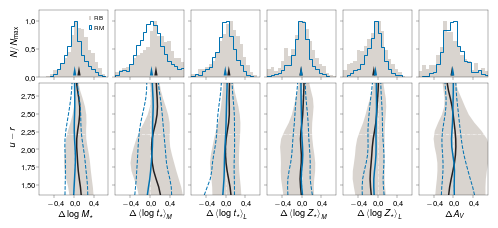

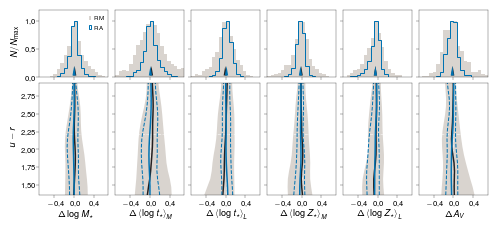

In [6]:
fig = delta_distributions((sdss_res,jpas_res), (sdss_lb,jpas_lb))
#fig.savefig("{}{}_vs_{}".format("img/", "jpas", "sdss"))
fig = delta_distributions((jpas_res,spec_res), (jpas_lb,spec_lb))
#fig.savefig("{}{}_vs_{}".format("img/", "spec", "jpas"))

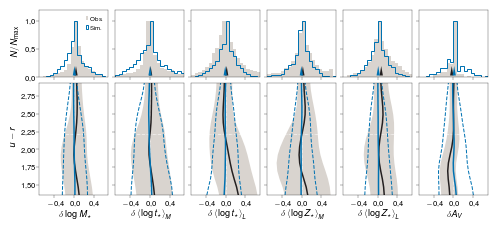

In [7]:
fig = delta_distributions((obs_con,tta_con), (r"Obs.",r"Sim."), delta, prop=(ocolor,lcolor), stats=(mean, lambda x: std(x, ddof=1)))
fig.savefig("{}{}_vs_{}".format(od, "tta", "obs"))

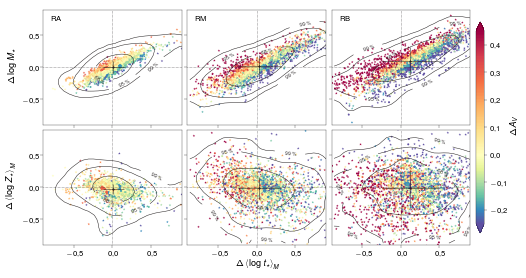

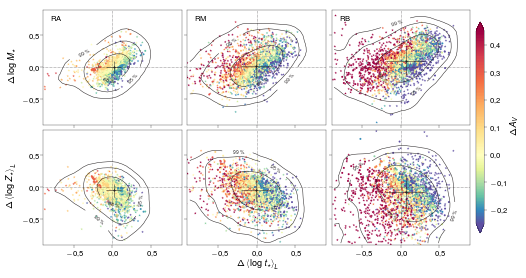

In [8]:
fig = residual_correlation_scatter((spec_res,jpas_res,sdss_res), (spec_lb,jpas_lb,sdss_lb), "log_t_M M log_Z_M Av".split())
fig.savefig("{}{}".format(od, "mass-age-met-ext_mw_trends"))
fig = residual_correlation_scatter((spec_res,jpas_res,sdss_res), (spec_lb,jpas_lb,sdss_lb), "log_t_L M log_Z_L Av".split())
fig.savefig("{}{}".format(od, "mass-age-met-ext_lw_trends"))

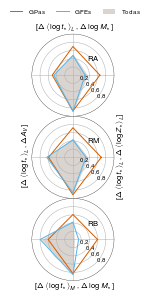

In [9]:
fig = degeneracies_plots((spec_res,jpas_res,sdss_res), (spec_lb,jpas_lb,sdss_lb), colors=(samples["hot"],samples["cold"]))
fig.savefig("{}{}".format(od, "degeneracies"))

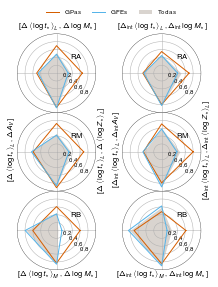

In [10]:
fig = degeneracies_plots_2d(((spec_res,jpas_res,sdss_res),(spec_noiseless_res,jpas_noiseless_res,sdss_noiseless_res)), (Delta,Delta_int), (spec_lb,jpas_lb,sdss_lb), colors=(samples["hot"],samples["cold"]))
#fig.savefig("{}{}".format(od, "degeneracies"))

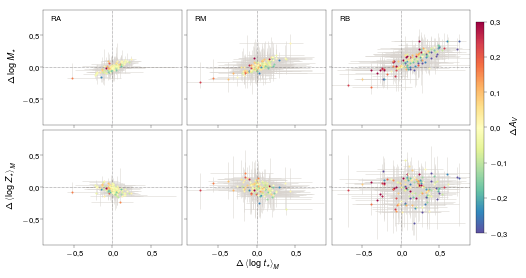

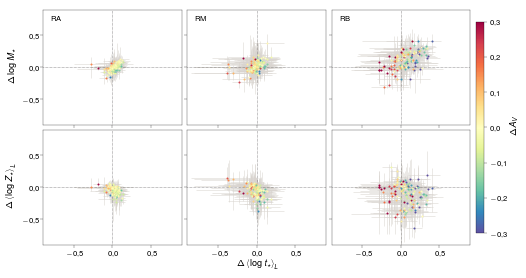

In [11]:
fig = individual_residual_correlation_scatter((spec_res,jpas_res,sdss_res), (spec_lb,jpas_lb,sdss_lb), properties="log_t_M M log_Z_M Av".split())
fig.savefig("{}{}".format(od, "mass-age-met-ext_mw_individual_trends"))
fig = individual_residual_correlation_scatter((spec_res,jpas_res,sdss_res), (spec_lb,jpas_lb,sdss_lb), properties="log_t_L M log_Z_L Av".split())
fig.savefig("{}{}".format(od, "mass-age-met-ext_lw_individual_trends"))

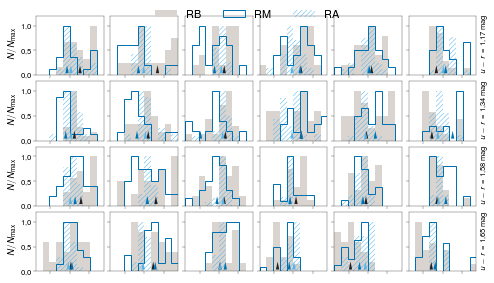

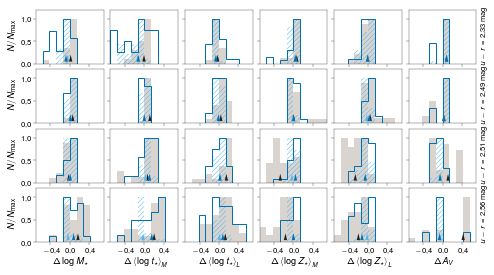

In [12]:
#fig = individual_residual_distributions((sdss_res,jpas_res,spec_res), (sdss_lb,jpas_lb,spec_lb))
fig = individual_masked_residual_distributions((sdss_res,jpas_res,spec_res), (sdss_lb,jpas_lb,spec_lb), lcolor<=2.22, show_xlabels=False)
fig.savefig("{}individual-residuals-sfgs".format(od))
fig = individual_masked_residual_distributions((sdss_res,jpas_res,spec_res), (sdss_lb,jpas_lb,spec_lb), lcolor>2.22, show_legend=False)
fig.savefig("{}individual-residuals-pags".format(od))

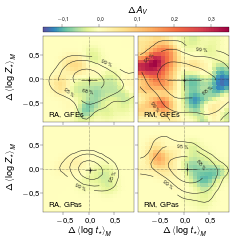

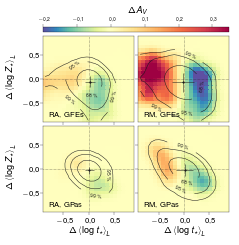

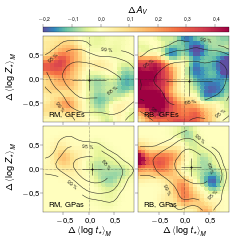

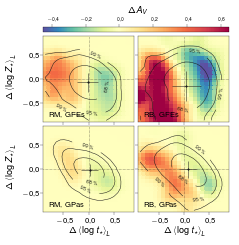

In [13]:
fig = dual_residual_maps((spec_res,jpas_res), (spec_lb,jpas_lb), ("log_t_M","log_Z_M","Av"), limits=((-0.9,+0.9),(-0.15,+0.35)))
#fig.savefig("{}{}".format("img/", "age-ext-met_mw_spec_jpas_trends"))
fig = dual_residual_maps((spec_res,jpas_res), (spec_lb,jpas_lb), ("log_t_L","log_Z_L","Av"), limits=((-0.9,+0.9),(-0.2,+0.35)))
#fig.savefig("{}{}".format("img/", "age-ext-met_lw_spec_jpas_trends"))

fig = dual_residual_maps((jpas_res,sdss_res), (jpas_lb,sdss_lb), ("log_t_M","log_Z_M","Av"), limits=((-0.9,+0.9),(-0.2,+0.45)))
#fig.savefig("{}{}".format("img/", "age-ext-met_mw_jpas_sdss_trends"))
fig = dual_residual_maps((jpas_res,sdss_res), (jpas_lb,sdss_lb), ("log_t_L","log_Z_L","Av"), limits=((-0.9,+0.9),(-0.45,+0.65)))
#fig.savefig("{}{}".format("img/", "age-ext-met_lw_jpas_sdss_trends"))

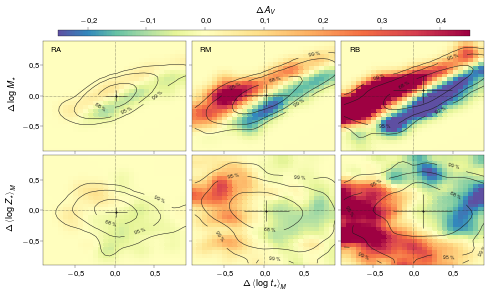

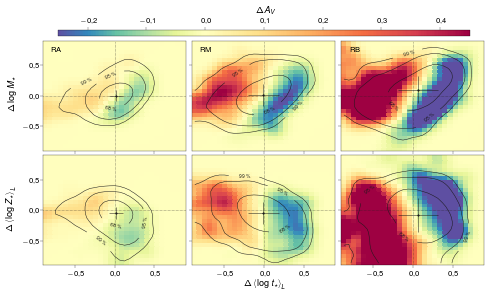

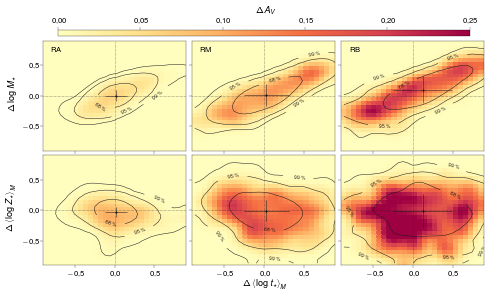

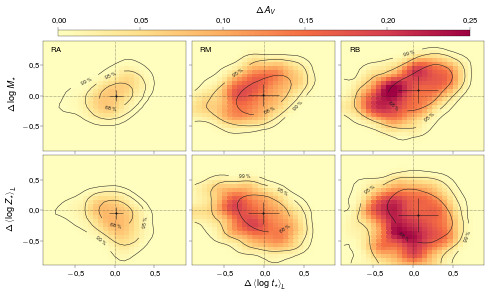

In [14]:
fig = residual_maps((spec_res,jpas_res,sdss_res), (spec_lb,jpas_lb,sdss_lb), "log_t_M M log_Z_M Av".split())
#fig.savefig("{}{}".format("img/", "mass-age-met-ext_mw_med"))
fig = residual_maps((spec_res,jpas_res,sdss_res), (spec_lb,jpas_lb,sdss_lb), "log_t_L M log_Z_L Av".split())
#fig.savefig("{}{}".format("img/", "mass-age-met-ext_lw_med"))

fig = residual_maps((spec_res,jpas_res,sdss_res), (spec_lb,jpas_lb,sdss_lb), "log_t_M M log_Z_M Av".split(), limits=((-0.9,+0.9),(0.0,+0.25)), stat=lambda data: (percentile(data, 84)-percentile(data, 16))/2.0)
#fig.savefig("{}{}".format("img/", "mass-age-met-ext_mw_pre"))
fig = residual_maps((spec_res,jpas_res,sdss_res), (spec_lb,jpas_lb,sdss_lb), "log_t_L M log_Z_L Av".split(), limits=((-0.9,+0.9),(0.0,+0.25)), stat=lambda data: (percentile(data, 84)-percentile(data, 16))/2.0)
#fig.savefig("{}{}".format("img/", "mass-age-met-ext_lw_pre"))

In [15]:
#TTA TABLE

dlabels = r"\dlogm \dmwla \dlwla \dmwlz \dlwlz \dextv".split()
masks = [sfgs, pags, algs]
mask_names = [sfgs_lb, pags_lb, algs_lb]
#--------------------------------------------------------------------------------

for i in xrange(len(kw)):
    bias_spec, pres_spec = [], []
    bias_jpas, pres_jpas = [], []
    bias_sdss, pres_sdss = [], []
    for mask in masks:
        bias_spec.append(median(spec_res[kw[i]][mask]))
        pres_spec.append(diff(percentile(spec_res[kw[i]][mask], [16,84]))[0]*0.5)
        
        bias_jpas.append(median(jpas_res[kw[i]][mask]))
        pres_jpas.append(diff(percentile(jpas_res[kw[i]][mask], [16,84]))[0]*0.5)
        
        bias_sdss.append(median(sdss_res[kw[i]][mask]))
        pres_sdss.append(diff(percentile(sdss_res[kw[i]][mask], [16,84]))[0]*0.5)

    for j in xrange(len(masks)):
        if j==0:
            print r"\multirow{3}{*}{%s}   &%10s &%10.3f &%10.3f & &%10.3f &%10.3f & &%10.3f &%10.3f\\" %\
            (dlabels[i], mask_names[j], bias_spec[j], pres_spec[j], bias_jpas[j], pres_jpas[j], bias_sdss[j], pres_sdss[j])
        else:
            print r"                          &%10s &%10.3f &%10.3f & &%10.3f &%10.3f & &%10.3f &%10.3f\\" %\
            (mask_names[j], bias_spec[j], pres_spec[j], bias_jpas[j], pres_jpas[j], bias_sdss[j], pres_sdss[j])
    print r"\hline"

\multirow{3}{*}{\dlogm}   &      GFEs &     0.001 &     0.101 & &     0.011 &     0.215 & &     0.091 &     0.264\\
                          &      GPas &     0.005 &     0.071 & &     0.019 &     0.125 & &     0.110 &     0.140\\
                          &     Todas &     0.004 &     0.092 & &     0.015 &     0.178 & &     0.102 &     0.216\\
\hline
\multirow{3}{*}{\dmwla}   &      GFEs &     0.003 &     0.159 & &     0.002 &     0.339 & &     0.101 &     0.454\\
                          &      GPas &     0.028 &     0.110 & &     0.065 &     0.193 & &     0.143 &     0.192\\
                          &     Todas &     0.012 &     0.139 & &     0.033 &     0.281 & &     0.124 &     0.370\\
\hline
\multirow{3}{*}{\dlwla}   &      GFEs &     0.018 &     0.098 & &    -0.023 &     0.214 & &     0.047 &     0.289\\
                          &      GPas &     0.009 &     0.086 & &     0.014 &     0.163 & &     0.081 &     0.187\\
                          &     Todas &     0.015 &     0.

In [16]:
#DISCREPANCIES TABLE

clabels = r"\clogm \cmwla \clwla \cmwlz \clwlz \cextv".split()
tta_masks = [sfgs, pags, algs]
obs_masks = [ocolor<=2.22, ocolor>2.22, ocolor>-999.99]
mask_names = [sfgs_lb, pags_lb, algs_lb]
#--------------------------------------------------------------------------------

for i in xrange(len(kw)):
    mean_dis_obs, mean_dis_tta = [], []
    std_dis_obs, std_dis_tta = [], []
    for tta_mask, obs_mask in zip(tta_masks, obs_masks):
        mean_dis_tta.append(mean(tta_con[kw[i]][tta_mask]))
        mean_dis_obs.append(mean(obs_con[kw[i]][obs_mask]))
        
        std_dis_tta.append(std(tta_con[kw[i]][tta_mask], ddof=1))
        std_dis_obs.append(std(obs_con[kw[i]][obs_mask], ddof=1))

    for j in xrange(len(tta_masks)):
        if j==0:
            print r"\multirow{3}{*}{%s}   &%10s &%10.3f &%10.3f & &%10.3f &%10.3f\\" %\
            (clabels[i], mask_names[j], mean_dis_tta[j], std_dis_tta[j], mean_dis_obs[j], std_dis_obs[j])
        else:
            print r"                          &%10s &%10.3f &%10.3f & &%10.3f &%10.3f\\" %\
            (mask_names[j], mean_dis_tta[j], std_dis_tta[j], mean_dis_obs[j], std_dis_obs[j])
    print r"\hline"

\multirow{3}{*}{\clogm}   &      GFEs &     0.016 &     0.224 & &     0.019 &     0.271\\
                          &      GPas &    -0.004 &     0.150 & &     0.065 &     0.130\\
                          &     Todas &     0.009 &     0.202 & &     0.041 &     0.215\\
\hline
\multirow{3}{*}{\cmwla}   &      GFEs &     0.019 &     0.357 & &     0.001 &     0.369\\
                          &      GPas &    -0.024 &     0.230 & &     0.031 &     0.179\\
                          &     Todas &     0.004 &     0.319 & &     0.016 &     0.292\\
\hline
\multirow{3}{*}{\clwla}   &      GFEs &    -0.010 &     0.262 & &     0.087 &     0.385\\
                          &      GPas &    -0.012 &     0.186 & &    -0.052 &     0.197\\
                          &     Todas &    -0.011 &     0.239 & &     0.019 &     0.315\\
\hline
\multirow{3}{*}{\cmwlz}   &      GFEs &    -0.013 &     0.251 & &    -0.020 &     0.444\\
                          &      GPas &     0.006 &     0.158 & &     0.071 &  

In [17]:
#DEGENERACIES TABLE

def model(x, pars):
    m, b = pars
    return m*x + b
def residual(pars, x, y):
    return y - model(x, pars)

def model_percent(x, pars):
    m, b = pars
    return abs(10**(m*log10(1+x/100.0))-1)*100.0
def slope(x, pars):
    m, b = pars
    return m*x

corr_planes = [
    ("log_t_L", "M"),
    ("log_t_L", "log_Z_L"),
    ("log_t_L", "Av"),
    ("log_t_M", "M"),
    ("log_t_M", "log_Z_M"),
    ("log_t_M", "Av")
]
res_aliases = {
    "M": r"\dlogm",
    "log_t_M": r"\dmwla",
    "log_t_L": r"\dlwla",
    "log_Z_M": r"\dmwlz",
    "log_Z_L": r"\dlwlz",
    "Av": r"\dextv"
}

masks = [sfgs, pags, algs]
mask_names = [sfgs_lb, pags_lb, algs_lb]

done_lw, done_mw = False, False
for i in xrange(len(corr_planes)):
    kw_x, kw_y = corr_planes[i]

    cor_spec = [
        corrcoef(spec_res[kw_x][sfgs], spec_res[kw_y][sfgs])[0,1],
        corrcoef(spec_res[kw_x][pags], spec_res[kw_y][pags])[0,1],
        corrcoef(spec_res[kw_x][algs], spec_res[kw_y][algs])[0,1]
    ]
    cor_jpas = [
        corrcoef(jpas_res[kw_x][sfgs], jpas_res[kw_y][sfgs])[0,1],
        corrcoef(jpas_res[kw_x][pags], jpas_res[kw_y][pags])[0,1],
        corrcoef(jpas_res[kw_x][algs], jpas_res[kw_y][algs])[0,1]
    ]
    cor_sdss = [
        corrcoef(sdss_res[kw_x][sfgs], sdss_res[kw_y][sfgs])[0,1],
        corrcoef(sdss_res[kw_x][pags], sdss_res[kw_y][pags])[0,1],
        corrcoef(sdss_res[kw_x][algs], sdss_res[kw_y][algs])[0,1]
    ]
    
    if i==0:
        print r"\hline"
        print r"%34s & %10s & %7s & %7s & %7s\\" % ("Plane", "Gal. type", spec_lb, jpas_lb, sdss_lb)
        print r"\hline"
    for j in xrange(len(masks)):
        if j==0:
            print r"\multirow{3}{*}{$[%s,%s]$} & %10s & %7.2f & %7.2f & %7.2f\\" % (res_aliases[kw_x], res_aliases[kw_y], mask_names[j], cor_spec[j], cor_jpas[j], cor_sdss[j])
        else:
            print r"%34s & %10s & %7.2f & %7.2f & %7.2f\\" % (" ", mask_names[j], cor_spec[j], cor_jpas[j], cor_sdss[j])
    print r"\hline"

\hline
                             Plane &  Gal. type &      RA &      RM &      RB\\
\hline
\multirow{3}{*}{$[\dlwla,\dlogm]$} &       GFEs &    0.48 &    0.42 &    0.42\\
                                   &       GPas &    0.70 &    0.72 &    0.61\\
                                   &      Todas &    0.52 &    0.47 &    0.45\\
\hline
\multirow{3}{*}{$[\dlwla,\dlwlz]$} &       GFEs &   -0.30 &   -0.32 &    0.14\\
                                   &       GPas &   -0.66 &   -0.69 &   -0.60\\
                                   &      Todas &   -0.35 &   -0.36 &    0.03\\
\hline
\multirow{3}{*}{$[\dlwla,\dextv]$} &       GFEs &   -0.47 &   -0.64 &   -0.80\\
                                   &       GPas &   -0.50 &   -0.59 &   -0.60\\
                                   &      Todas &   -0.47 &   -0.63 &   -0.77\\
\hline
\multirow{3}{*}{$[\dmwla,\dlogm]$} &       GFEs &    0.88 &    0.86 &    0.86\\
                                   &       GPas &    0.87 &    0.91 &    0.83\\
     

In [18]:
table = genfromtxt("./data/sample-sim/SSAG_set_recipe.log", dtype=None, names=True)
table = table[argsort(table["UMAG"]-table["RMAG"])][table["AV_EFF"]<=1.5]
ur = sorted(ssag_tta[::NR]["u"]-ssag_tta[::NR]["r"])

table["TFORM"] /= 1e9
table["GAMMA"] *= 1e9
table["BURSTAGE"] /= 1e9
table["BURSTEXT"] /= 1e6
table["TCUT"] /= 1e9
table["TAUCUT"] /= 1e6

names = "TFORM GAMMA BURSTAGE BURSTEXT A TCUT TAUCUT Z SIGMA TAU MU".split()

fields = r"$u-r$", r"$t_\text{form}$", r"$1/\tau$", r"$t_\text{brote}$", r"$t_\text{ext}$", r"$A$", r"$t_\text{trunc}$", r"$\tau_\text{trunc}$", r"$Z$", r"$\sigma_v$", r"$\tau_V$", r"$\mu$"
units = r"", r"(Ga\~no)", r"($\text{Ga\~no}^{-1}$)", r"(Ga\~no)", r"(Ma\~no)", r"", r"(Ga\~no)", r"(Ma\~no)", r"(Z$\odot$)", r"(km/s)", r"", r""
print r"\hline"
print r"%s & %s & %s & %s & %s & %s & %s & %s & %s & %s & %s & %s\\" % fields
print r"%s & %s & %s & %s & %s & %s & %s & %s & %s & %s & %s & %s\\" % units
print r"\hline"
for i in xrange(table.size):
    row = [ur[i]] + [table[i][name] for name in names]
    if row[6]==0.0:
        row[6] = "--"
        row[7] = "--"
        print r"%7.3f & %7.2f & %7.3f & %7.2f & %7.2f & %7.2f & %7s & %7s & %7.2f & %7.2f & %7.3f & %7.3f\\" % tuple(row)
    else:
        print r"%7.3f & %7.2f & %7.3f & %7.2f & %7.2f & %7.2f & %7.2f & %7.2f & %7.2f & %7.2f & %7.3f & %7.3f\\" % tuple(row)
print r"\hline"

\hline
$u-r$ & $t_\text{form}$ & $1/\tau$ & $t_\text{brote}$ & $t_\text{ext}$ & $A$ & $t_\text{trunc}$ & $\tau_\text{trunc}$ & $Z$ & $\sigma_v$ & $\tau_V$ & $\mu$\\
 & (Ga\~no) & ($\text{Ga\~no}^{-1}$) & (Ga\~no) & (Ma\~no) &  & (Ga\~no) & (Ma\~no) & (Z$\odot$) & (km/s) &  & \\
\hline
  0.971 &    1.90 &   0.033 &    1.04 &  202.56 &    0.32 &      -- &      -- &    1.78 &  141.11 &   0.540 &   0.176\\
  1.097 &    1.68 &   0.409 &    1.48 &   64.05 &    0.04 &      -- &      -- &    1.59 &  142.07 &   2.714 &   0.034\\
  1.168 &    2.40 &   0.057 &    2.33 &  286.12 &    1.16 &      -- &      -- &    0.70 &  235.72 &   0.436 &   0.288\\
  1.190 &    1.61 &   0.448 &    1.27 &  255.00 &    0.03 &      -- &      -- &    0.17 &  375.12 &   1.994 &   0.237\\
  1.199 &    1.90 &   0.871 &    0.90 &  286.12 &    0.13 &      -- &      -- &    0.76 &  197.10 &   0.508 &   0.152\\
  1.226 &    4.50 &   0.194 &    2.92 &  202.56 &    0.19 &      -- &      -- &    0.32 &  357.40 &   0.798 &   0.

In [19]:
table = ssag_tta[::NR]
table = table[argsort(table["u"]-table["r"])]

table["M_lib"] = 10**table["M_lib"]/(10**(-0.4*(table["r"]-4.50)))

names = "M_lib log_t_M_lib log_t_L_lib log_Z_M_lib Av_lib".split()

fields = r"$u-r$", r"$M/L_{\star,r}$", r"$\lwla$", r"$\mwla$", r"$\log(Z)$", r"$\extv$"
units = r"", r"(M$\odot$/L$\odot$)", r"(log/a\~no)", r"(log/a\~no)", r"(log/Z$\odot$)", r""
print r"\hline"
print r"%s & %s & %s & %s & %s & %s\\" % fields
print r"%s & %s & %s & %s & %s & %s\\" % units
print r"\hline"
for i in xrange(table.size):
    row = [table[i]["u"]-table[i]["r"]] + [table[i][name] for name in names]
    print r"%7.3f & %7.3f & %7.3f & %7.3f & %7.3f & %7.3f\\" % tuple(row)
print r"\hline"

\hline
$u-r$ & $M/L_{\star,r}$ & $\lwla$ & $\mwla$ & $\log(Z)$ & $\extv$\\
 & (M$\odot$/L$\odot$) & (log/a\~no) & (log/a\~no) & (log/Z$\odot$) & \\
\hline
  0.971 &   0.729 &   8.880 &   8.458 &   0.251 &   0.145\\
  1.097 &   0.734 &   8.874 &   8.536 &   0.201 &   0.209\\
  1.168 &   1.017 &   9.164 &   8.677 &  -0.155 &   0.163\\
  1.190 &   0.752 &   8.988 &   8.673 &  -0.121 &   0.110\\
  1.199 &   0.726 &   8.853 &   8.513 &  -0.759 &   0.626\\
  1.226 &   0.976 &   9.157 &   8.634 &   0.076 &   0.226\\
  1.265 &   0.825 &   8.716 &   8.484 &   0.389 &   0.472\\
  1.265 &   0.873 &   8.902 &   8.625 &  -0.103 &   0.370\\
  1.279 &   1.098 &   9.331 &   8.869 &  -0.495 &   0.114\\
  1.306 &   1.364 &   9.456 &   8.945 &  -0.742 &   0.200\\
  1.324 &   1.559 &   9.197 &   8.688 &   0.147 &   0.483\\
  1.328 &   1.586 &   9.437 &   8.905 &  -0.181 &   0.134\\
  1.335 &   0.926 &   8.762 &   8.572 &  -0.060 &   0.611\\
  1.337 &   0.972 &   9.150 &   8.867 &  -0.790 &   0.324\\
  1.3